# Assess generalizability of the model by applying to a different plate

**NOTE:** We currently will only be applying the model to Plate 3, split by treatments.

## Import libraries

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from joblib import load
from sklearn.metrics import precision_recall_curve, auc

sys.path.append("../../utils")
from eval_utils import generate_confusion_matrix_df, generate_f1_score_df
from training_utils import get_X_y_data

## Set paths and variables

In [2]:
# Directory with plate datasets
data_dir = pathlib.Path("../../3.process_cfret_features/data/single_cell_profiles")

# Directory with models
models_dir = pathlib.Path("../0.train_logistic_regression/models")

# Directory for model figures output
fig_dir = pathlib.Path("./figures")
fig_dir.mkdir(exist_ok=True)

# Directory for probability data to be saved
prob_dir = pathlib.Path("./prob_data")
prob_dir.mkdir(exist_ok=True)

# Load in each model individually
final_model = load(
    pathlib.Path(f"{models_dir}/log_reg_fs_plate_4_final_downsample.joblib")
)
shuffled_model = load(
    pathlib.Path(f"{models_dir}/log_reg_fs_plate_4_shuffled_downsample.joblib")
)

# Encoder path
encoder_path = pathlib.Path(
    "../0.train_logistic_regression/encoder_results/label_encoder_log_reg_fs_plate_4.joblib"
)

## Load in Plate 4 fs data to extract column names to filter from the other plates

In [3]:
# Read metadata and filter columns directly in one step
model_column_names = [
    col for col in pq.read_metadata(f"{data_dir}/localhost231120090001_sc_feature_selected.parquet").schema.names
    if not col.startswith("Metadata_")
]

print(len(model_column_names))
print(model_column_names)

625
['Cytoplasm_AreaShape_BoundingBoxArea', 'Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_FormFactor', 'Cytoplasm_AreaShape_MajorAxisLength', 'Cytoplasm_AreaShape_MinorAxisLength', 'Cytoplasm_AreaShape_Perimeter', 'Cytoplasm_AreaShape_Solidity', 'Cytoplasm_AreaShape_Zernike_0_0', 'Cytoplasm_AreaShape_Zernike_1_1', 'Cytoplasm_AreaShape_Zernike_2_0', 'Cytoplasm_AreaShape_Zernike_2_2', 'Cytoplasm_AreaShape_Zernike_3_1', 'Cytoplasm_AreaShape_Zernike_3_3', 'Cytoplasm_AreaShape_Zernike_4_0', 'Cytoplasm_AreaShape_Zernike_4_2', 'Cytoplasm_AreaShape_Zernike_5_1', 'Cytoplasm_AreaShape_Zernike_5_3', 'Cytoplasm_AreaShape_Zernike_6_0', 'Cytoplasm_AreaShape_Zernike_6_2', 'Cytoplasm_AreaShape_Zernike_7_1', 'Cytoplasm_AreaShape_Zernike_7_3', 'Cytoplasm_AreaShape_Zernike_8_0', 'Cytoplasm_AreaShape_Zernike_8_2', 'Cytoplasm_AreaShape_Zernike_8_4', 'Cytoplasm_AreaShape_Zernike_8_6', 'Cytoplasm_AreaShape_Zernike_9_1', 'Cytoplasm_Ar

## Load in Plate 3 normalized data and drop any rows that have NaNs in the model feature columns

In [4]:
# Define common columns for merging
common_columns = [
    "Metadata_Well",
    "Metadata_Site",
    "Metadata_Nuclei_Location_Center_X",
    "Metadata_Nuclei_Location_Center_Y",
]

# Load and merge the data in one step
plate_3_df = pd.read_parquet(f"{data_dir}/localhost230405150001_sc_normalized.parquet")
annotated_df = pd.read_parquet(
    f"{data_dir}/localhost230405150001_sc_annotated.parquet"
)[["Nuclei_Neighbors_NumberOfNeighbors_Adjacent"] + common_columns].rename(
    columns={"Nuclei_Neighbors_NumberOfNeighbors_Adjacent": "Metadata_Nuclei_Neighbors"}
)

plate_3_df = plate_3_df.merge(annotated_df, on=common_columns, how="left").dropna(
    subset=model_column_names
)

# Capitalize the cell type values
plate_3_df["Metadata_cell_type"] = plate_3_df["Metadata_cell_type"].str.capitalize()

# Output
print(plate_3_df["Metadata_treatment"].unique())
print(plate_3_df.shape)
plate_3_df.head()

['DMSO' 'drug_x' 'TGFRi']
(20861, 2023)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256,Metadata_Nuclei_Neighbors
0,B,2,9,Failing,rejected,DMSO,221.046761,137.115493,246.602800,109.285755,...,-0.361815,-0.278543,-0.278748,-0.281016,-0.280648,-0.321748,-0.324540,-0.326290,-0.325595,0
1,B,2,9,Failing,rejected,DMSO,690.596142,183.067828,716.170091,177.132195,...,-0.373654,2.297362,2.519445,2.039900,1.946821,-0.204002,-0.190676,-0.215768,-0.227077,0
2,B,2,9,Failing,rejected,DMSO,626.561490,206.923698,623.943740,199.906440,...,-0.408046,-0.254027,-0.252227,-0.255444,-0.256202,-0.331222,-0.330529,-0.332888,-0.334313,0
3,B,2,9,Failing,rejected,DMSO,559.448583,220.688160,528.646623,196.955552,...,-0.370338,-0.168390,-0.168077,-0.168909,-0.163799,-0.239871,-0.229786,-0.230989,-0.240673,0
4,B,2,9,Failing,rejected,DMSO,909.019946,247.694340,897.965996,253.621836,...,-0.401941,0.015661,0.061135,0.059207,0.000078,-0.369169,-0.368101,-0.369411,-0.368442,0


## Filter the Plate 3 data to only include metadata and the model feature columns

In [5]:
# Extract metadata columns from the plate
metadata_columns = [col for col in plate_3_df.columns if col.startswith("Metadata_")]

# Extract feature columns that don't start with "Metadata_"
feature_columns = [col for col in plate_3_df.columns if not col.startswith("Metadata_")]

# Filter columns in data frame to only include those in the model
filtered_feature_columns = [
    col for col in plate_3_df.columns if col in model_column_names
]

# Filter the DataFrame to keep only the desired columns
plate_3_df = plate_3_df[metadata_columns + filtered_feature_columns]

plate_3_df

,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumVariance_ER_3_01_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,B,2,9,Failing,rejected,DMSO,221.046761,137.115493,246.602800,109.285755,...,-0.035117,-0.619206,-0.393448,0.938869,0.771698,0.406068,0.374039,-0.138748,-0.266794,-0.305486
1,B,2,9,Failing,rejected,DMSO,690.596142,183.067828,716.170091,177.132195,...,0.290339,-0.421502,-0.618520,0.198305,-0.199667,0.424753,0.323462,-0.219449,1.697858,-0.175679
2,B,2,9,Failing,rejected,DMSO,626.561490,206.923698,623.943740,199.906440,...,-0.319312,-0.627080,-0.213998,0.557294,0.715474,0.783465,0.531513,-0.126487,-0.242152,-0.312005
3,B,2,9,Failing,rejected,DMSO,559.448583,220.688160,528.646623,196.955552,...,0.817875,-0.410279,0.066951,0.279879,0.531243,0.697668,0.386800,-0.168629,-0.145371,-0.205381
4,B,2,9,Failing,rejected,DMSO,909.019946,247.694340,897.965996,253.621836,...,0.076669,0.784110,0.796587,-0.602722,-0.539279,0.971781,0.969710,-0.432344,-0.024062,-0.346036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20860,G,10,9,Failing,rejected,DMSO,417.553262,678.670439,411.069742,701.062876,...,1.123192,0.046973,-0.009479,0.114781,0.643506,-0.684759,0.097293,-0.305203,-0.227936,0.028462
20861,G,10,9,Failing,rejected,DMSO,498.481236,693.440765,520.422886,716.795365,...,0.963710,-1.455090,-1.226030,-1.289907,-0.041940,-1.508309,-1.715050,0.796987,0.261156,0.822093
20862,G,10,9,Failing,rejected,DMSO,318.200661,728.801228,315.515137,756.658659,...,0.471925,0.861197,0.453347,0.608231,0.769096,0.444195,0.553663,-0.394810,-0.261051,-0.266575
20863,G,10,9,Failing,rejected,DMSO,491.591029,876.989886,498.053700,851.270108,...,0.666525,0.470270,0.667388,0.877030,0.790684,0.988244,0.985433,-0.379780,-0.269060,-0.312917


## Create a data frame with precision recall data

In [6]:
# Initialize empty lists to store data for each iteration
precision_list = []
recall_list = []
threshold_list = []
model_type_list = []
metadata_neighbors_list = []
metadata_cell_type_list = []
metadata_treatment_list = []  # New list for metadata_treatment

# Loop over each model in the models directory
for model_path in models_dir.iterdir():
    if model_path.is_dir() or model_path.suffix != ".joblib":
        continue  # Skip directories or files that are not model files

    print("Evaluating", model_path.stem.split("_")[5], "model...")
    model_type = model_path.stem.split("_")[5]  # Extract model type

    # Initialize empty lists to store data for each model
    model_precision_list = []
    model_recall_list = []
    model_threshold_list = []

    # Load in model and label encoder once, since they don't change across iterations
    model = load(model_path)
    le = load(encoder_path)

    # Get the X and y data for the entire dataset at once
    X, y = get_X_y_data(df=plate_3_df, label="Metadata_cell_type")

    # Extract the metadata columns for the entire dataset at once
    metadata_neighbors = plate_3_df["Metadata_Nuclei_Neighbors"]
    metadata_cell_type = plate_3_df["Metadata_cell_type"]
    metadata_treatment = plate_3_df["Metadata_treatment"]

    # Assign y classes to correct binary using label encoder results
    y_binary = le.transform(y)

    # Predict class probabilities for morphology feature data
    predicted_probs = model.predict_proba(X)

    # Calculate the precision, recall data
    precision, recall, threshold = precision_recall_curve(
        y_binary, predicted_probs[:, -1]
    )
    threshold = np.append(threshold, np.nan)

    # Append data to lists for the current model
    model_precision_list.extend(precision.tolist())
    model_recall_list.extend(recall.tolist())
    model_threshold_list.extend(threshold.tolist())

    # Adjust metadata lists to match the length of precision-recall data
    metadata_neighbors_list.extend(metadata_neighbors.tolist())
    metadata_cell_type_list.extend(metadata_cell_type.tolist())
    metadata_treatment_list.extend(metadata_treatment.tolist())  # Append treatment data

    # Extend model_type_list once per model
    model_type_list.extend([model_type] * len(model_precision_list))

    # Extend precision_list, recall_list, and threshold_list with the data for the current model
    precision_list.extend(model_precision_list)
    recall_list.extend(model_recall_list)
    threshold_list.extend(model_threshold_list)

# Ensure all lists are the same length before creating the DataFrame
min_length = min(
    len(precision_list),
    len(recall_list),
    len(threshold_list),
    len(model_type_list),
    len(metadata_neighbors_list),
    len(metadata_cell_type_list),
    len(metadata_treatment_list),  # Include metadata_treatment here
)

# Slice all lists to the same length
precision_list = precision_list[:min_length]
recall_list = recall_list[:min_length]
threshold_list = threshold_list[:min_length]
model_type_list = model_type_list[:min_length]
metadata_neighbors_list = metadata_neighbors_list[:min_length]
metadata_cell_type_list = metadata_cell_type_list[:min_length]
metadata_treatment_list = metadata_treatment_list[:min_length]  # Slice the new list

# Create a DataFrame from the accumulated data, including Metadata columns
pr_df = pd.DataFrame(
    {
        "Precision": precision_list,
        "Recall": recall_list,
        "Threshold": threshold_list,
        "Model_Type": model_type_list,
        "Metadata_Nuclei_Neighbors": metadata_neighbors_list,
        "Metadata_cell_type": metadata_cell_type_list,
        "Metadata_treatment": metadata_treatment_list,  # Add the new treatment column
    }
)

# Drop any NA data
pr_df.dropna(inplace=True)

# Show output of all data
print(pr_df.shape)
pr_df.head()

Evaluating shuffled model...
Evaluating final model...
(41721, 7)


,Precision,Recall,Threshold,Model_Type,Metadata_Nuclei_Neighbors,Metadata_cell_type,Metadata_treatment
0,0.205024,1.0,0.012550,shuffled,0,Failing,DMSO
1,0.205034,1.0,0.014076,shuffled,0,Failing,DMSO
2,0.205043,1.0,0.019792,shuffled,0,Failing,DMSO
3,0.205053,1.0,0.019884,shuffled,0,Failing,DMSO
4,0.205063,1.0,0.024067,shuffled,0,Failing,DMSO


## Create PR curve with only DMSO (control) data to assess performance

Failing    9150
Healthy    1366
Name: Metadata_cell_type, dtype: int64


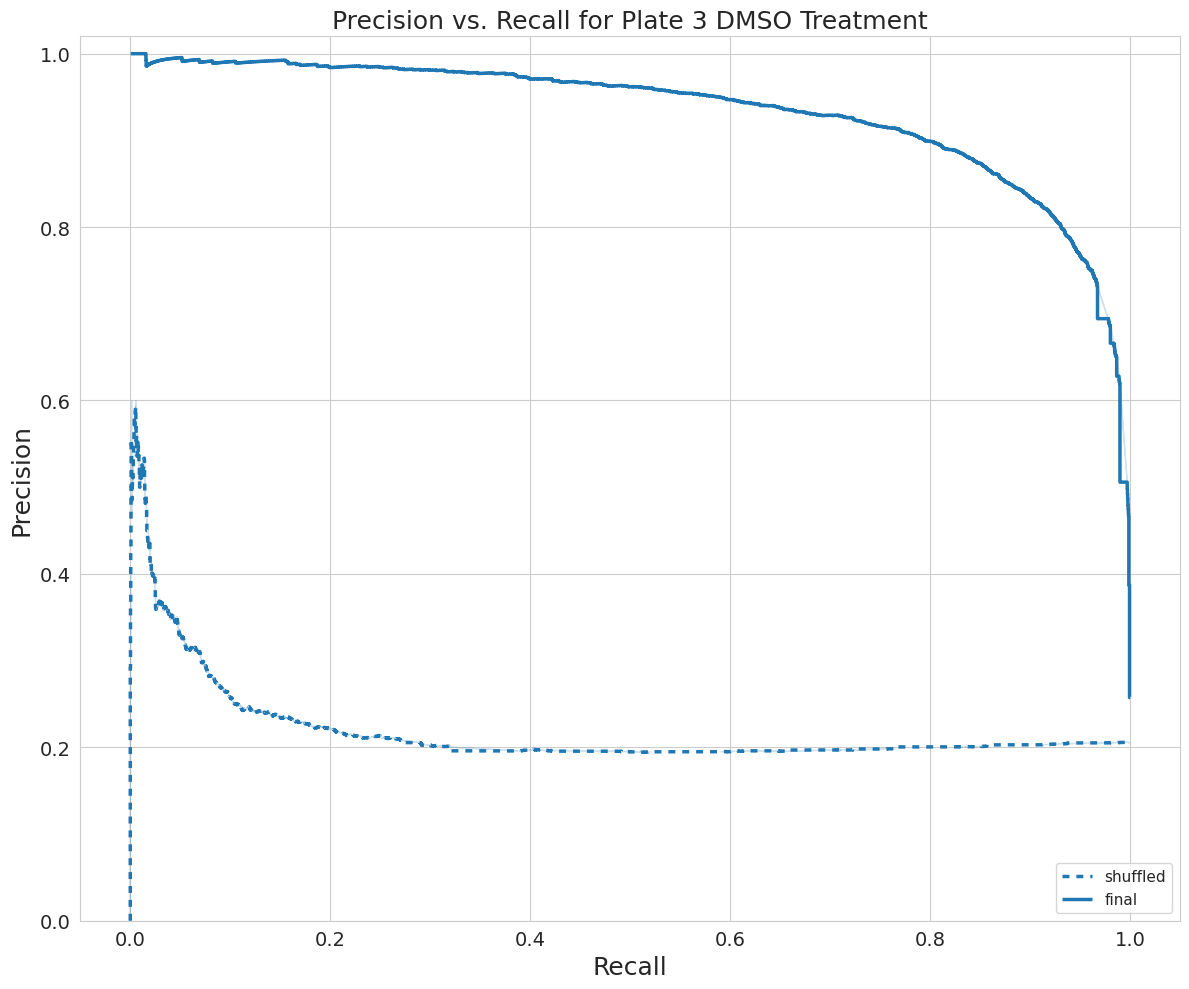

In [7]:
# PR curves with only DMSO cells from Plate 3
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Filter data frame to only show "DMSO" data
dmso_df = pr_df[(pr_df["Metadata_treatment"] == "DMSO")].copy()
# Combine model and data type as one column for plotting
dmso_df["Data Split"] = "DMSO (all features)"
dmso_df.rename(columns={"Model_Type": "Model Type"}, inplace=True)
print(dmso_df[dmso_df["Model Type"] == "final"]["Metadata_cell_type"].value_counts())

sns.lineplot(
    x="Recall",
    y="Precision",
    style="Model Type",
    dashes={"final": (1, 0), "shuffled": (2, 2)},
    drawstyle="steps",
    data=dmso_df,
    linewidth=2.5,  # Adjust the line width as needed
)

plt.legend(loc="lower right", fontsize=11)
plt.ylim(bottom=0.0, top=1.02)
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.title("Precision vs. Recall for Plate 3 DMSO Treatment", fontsize=18)

# Adjust x-axis and y-axis ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(f"{fig_dir}/precision_recall_plate3_DMSO_only.png", dpi=500)

plt.show()

In [8]:
# Filter the dataframe for the final model with DMSO treatment
final_dmso_df = dmso_df[dmso_df["Model Type"] == "final"]

# Calculate AUPRC for DMSO data (considered as testing)
dmso_auprc = auc(final_dmso_df["Recall"], final_dmso_df["Precision"])

# Output the result
print(f"AUPRC for DMSO Only Data: {dmso_auprc:.4f}")

AUPRC for DMSO Only Data: 0.9327


## Create PR curve plot with the heldout plate DMSO data and PR curve data from the supplemental models

In [9]:
# Load in PR curve data from the supplemental models
actin_rest_pr_data = pd.read_parquet(
    "../1.evaluate_models/results/precision_recall_actin_rest_models.parquet"
)

# Select the required columns from both dataframes
actin_rest_selected = actin_rest_pr_data[
    ["Precision", "Recall", "Model Type", "Data Split"]
]
dmso_selected = dmso_df[["Precision", "Recall", "Model Type", "Data Split"]]

# Vertically concatenate the two dataframes
merged_dmso_actin_rest_df = pd.concat(
    [actin_rest_selected, dmso_selected], axis=0, ignore_index=True
)

merged_dmso_actin_rest_df.head()

,Precision,Recall,Model Type,Data Split
0,0.374428,1.0,shuffled,testing (actin)
1,0.374529,1.0,shuffled,testing (actin)
2,0.374630,1.0,shuffled,testing (actin)
3,0.374731,1.0,shuffled,testing (actin)
4,0.374832,1.0,shuffled,testing (actin)


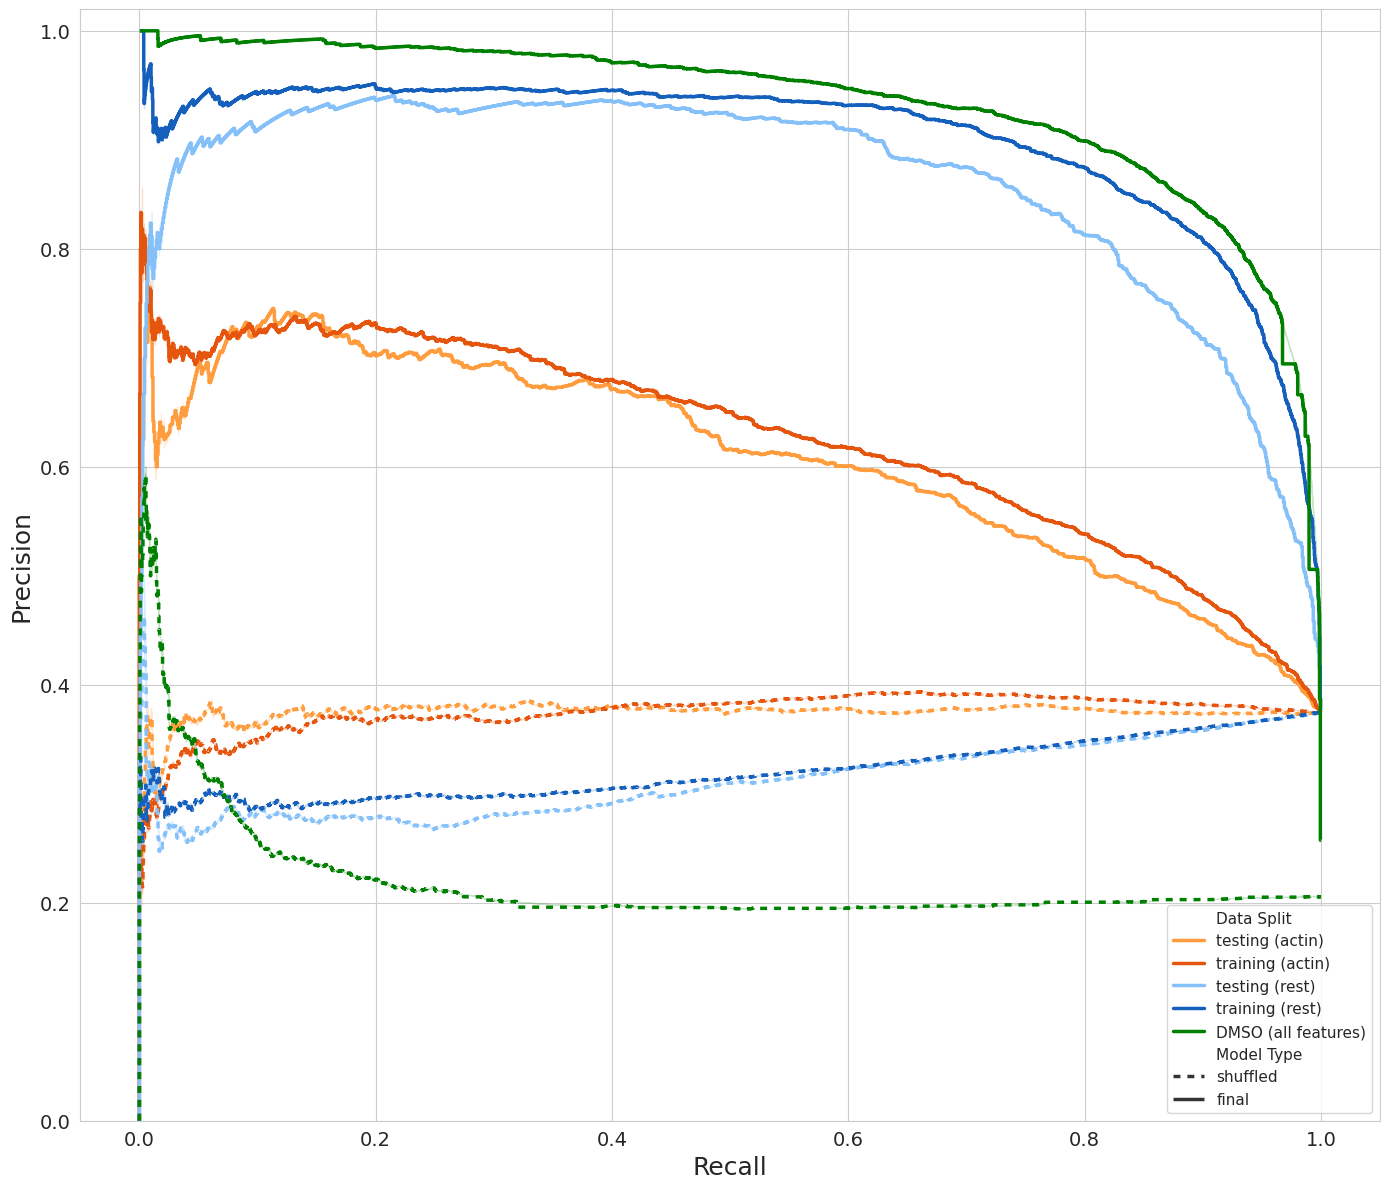

In [10]:
# Create a custom color palette
palette = {
    "training (rest)": "#1560bd",  # Darker blue
    "testing (rest)": "#85c0f9",  # Lighter blue
    "training (actin)": "#e6550d",  # Darker orange
    "testing (actin)": "#ff9c3d",  # Lighter orange
    "DMSO (all features)": "#008000",  # Green
}

# Create PR curve plot
plt.figure(figsize=(14, 12))
sns.set_style("whitegrid")

sns.lineplot(
    x="Recall",
    y="Precision",
    hue="Data Split",
    style="Model Type",
    dashes={"final": (1, 0), "shuffled": (2, 2)},
    drawstyle="steps",
    data=merged_dmso_actin_rest_df,
    palette=palette,
    linewidth=2.5,  # Adjust the line width as needed
)

plt.legend(loc="lower right", fontsize=11)
plt.ylim(bottom=0.0, top=1.02)
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)

# Adjust x-axis and y-axis ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(f"{fig_dir}/precision_recall_DMSO_plate3_actin_rest.png", dpi=500)

plt.show()

## Create PR curves for each neighbor

0 neighbors     18206
1 neighbor       2398
2+ neighbors      256
Name: Neighbors_Group, dtype: int64


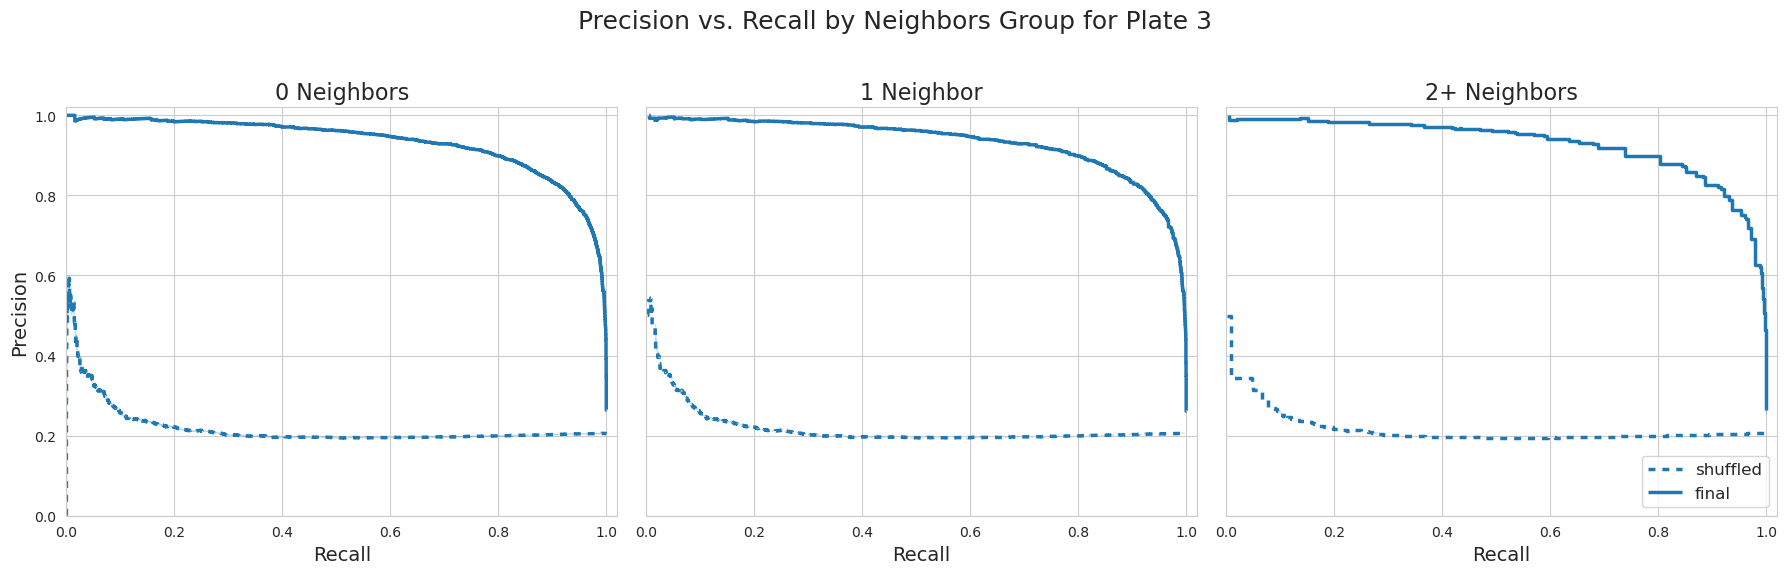

In [11]:
# Map Metadata_Nuclei_Neighbors to 0, 1, and 2+ neighbors
pr_df["Neighbors_Group"] = pr_df["Metadata_Nuclei_Neighbors"].apply(
    lambda x: "0 neighbors" if x == 0 else ("1 neighbor" if x == 1 else "2+ neighbors")
)
print(pr_df[pr_df["Model_Type"] == "final"]["Neighbors_Group"].value_counts())

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set_style("whitegrid")

# Define the neighbor groups and corresponding titles
neighbor_groups = ["0 neighbors", "1 neighbor", "2+ neighbors"]
titles = ["0 Neighbors", "1 Neighbor", "2+ Neighbors"]

# Loop over each group and corresponding axis
for i, (group, title) in enumerate(zip(neighbor_groups, titles)):
    group_df = pr_df[pr_df["Neighbors_Group"] == group]

    sns.lineplot(
        x="Recall",
        y="Precision",
        style="Model_Type",
        dashes={"final": (1, 0), "shuffled": (2, 2)},
        drawstyle="steps",
        data=group_df,
        linewidth=2.5,
        ax=axes[i],  # Specify the current axis
        legend=False if i < 2 else "auto",  # Suppress legend on the first two plots
    )

    # Set title and adjust limits for each subplot
    axes[i].set_title(f"{title}", fontsize=16)
    axes[i].set_xlim(0.0, 1.02)
    axes[i].set_ylim(0.0, 1.02)
    axes[i].set_xlabel("Recall", fontsize=14)
    if i == 0:
        axes[i].set_ylabel("Precision", fontsize=14)

# Adjust legend, layout, and display
axes[2].legend(loc="lower right", fontsize=12)  # Legend in the last subplot only
plt.suptitle("Precision vs. Recall by Neighbors Group for Plate 3", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.savefig(f"{fig_dir}/precision_recall_plate3_neighbors.png", dpi=500)
plt.show()

## Extract final model predicted probabilities for each treatment

In [12]:
# Create an empty DataFrame to store the results
combined_prob_df = pd.DataFrame()

for model_path in models_dir.iterdir():
    if model_path.is_dir() or model_path.suffix != ".joblib":
        continue  # Skip directories or files that are not model files

    # Get the model type
    model_type = model_path.stem.split("_")[5]

    print(f"Extracting {model_type} probabilities from plate_3 data...")

    # Load in model to apply to dataset
    model = load(model_path)

    # Load in label encoder
    le = load(encoder_path)

    # Get unique cell types and their corresponding encoded values
    unique_labels = le.classes_
    encoded_values = le.transform(unique_labels)

    # Create a dictionary mapping encoded values to original labels
    label_dict = dict(zip(encoded_values, unique_labels))

    # Use plate_3_df directly
    data_df = plate_3_df.reset_index(drop=True)

    # Load in X data to get predicted probabilities
    X, _ = get_X_y_data(df=data_df, label="Metadata_cell_type")

    # Predict class probabilities for morphology feature data
    predicted_probs = model.predict_proba(X)

    # Storing probabilities in a pandas DataFrame
    prob_df = pd.DataFrame(predicted_probs, columns=model.classes_)

    # Update column names in prob_df using the dictionary and add suffix "_probas"
    prob_df.columns = [label_dict[col] + "_probas" for col in prob_df.columns]

    # Add a new column called predicted_label for each row
    prob_df["predicted_label"] = prob_df.apply(lambda row: row.idxmax()[:-7], axis=1)

    # Select metadata columns from the data
    metadata_columns = data_df.filter(like="Metadata_")

    # Combine metadata columns with predicted probabilities DataFrame based on index
    prob_df = prob_df.join(metadata_columns)

    # Add a new column for model_type
    prob_df["model_type"] = model_type

    # Append the probability DataFrame to the combined DataFrame
    combined_prob_df = pd.concat([combined_prob_df, prob_df], ignore_index=True)

# Save combined prob data
combined_prob_df.to_csv(f"{prob_dir}/combined_plate_3_predicted_proba.csv", index=False)

Extracting shuffled probabilities from plate_3 data...
Extracting final probabilities from plate_3 data...


In [13]:
# Filter for rows where treatment is "TGFRi" and cell type is "Failing"
tgfri_failing_df = combined_prob_df[
    (combined_prob_df["Metadata_treatment"] == "TGFRi")
    & (combined_prob_df["Metadata_cell_type"] == "Failing")
]

# Count of rows with predicted label as "Healthy"
healthy_count = (tgfri_failing_df["predicted_label"] == "Healthy").sum()

# Total count of rows with Metadata_treatment as "TGFRi" and Metadata_cell_type as "Failing"
total_failing_tgfri_count = len(tgfri_failing_df)

# Calculate the proportion
proportion_healthy = (
    healthy_count / total_failing_tgfri_count if total_failing_tgfri_count != 0 else 0
)

print(
    "The proportion of failing cells with TGFRi treatment that are predicted as healthy is",
    proportion_healthy,
)

The proportion of failing cells with TGFRi treatment that are predicted as healthy is 0.8268215417106652
